In [1]:
import torch
from torch import Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random
import numpy as np

from src.util import get_names_list, get_chars, get_itos_stoi

In [10]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = torch.tensor([4.0, 5.0, 6.0], requires_grad=True)

def func(params: list[Tensor]) -> None:
    z = sum(x * y)
    z.backward()

    for p in params:
        p.data -= 1.0 * p.grad

print(x, y)
func((x, y))
print(x, y)


tensor([1., 2., 3.], requires_grad=True) tensor([4., 5., 6.], requires_grad=True)
tensor([-3., -3., -3.], requires_grad=True) tensor([3., 3., 3.], requires_grad=True)


In [2]:
words: list[str] = get_names_list()

In [3]:
chars: str = get_chars()
itos, stoi = get_itos_stoi()

In [4]:
# HyperParamters
EMBEDDING_SIZE = 20
CHARSET_SIZE = 27
CONTEXT_LENGTH = 5
NUM_HIDDEN_NEURONS = 500
LEARNING_RATE = 0.1
NUM_EPOCHS = 100_000

BATCH_SIZE = 128 

In [5]:
# Build the Dataset
def build_dataset(words) -> tuple[Tensor, Tensor]:
    X, Y = [], []
    for w in words:
        context: list[int] = [0] * CONTEXT_LENGTH
        for ch in w + ".":
            idx: int = stoi[ch]
            X.append(context)
            Y.append(idx)
            context: list[int] = context[1:] + [idx]
        
    X: Tensor = torch.tensor(X)
    Y: Tensor = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [6]:
_rng = torch.Generator().manual_seed(2147483647)

C: Tensor = torch.randn((CHARSET_SIZE, EMBEDDING_SIZE), requires_grad=True, generator = _rng)

W1: Tensor = torch.randn((EMBEDDING_SIZE * CONTEXT_LENGTH, NUM_HIDDEN_NEURONS), generator = _rng, requires_grad=True)
b1: Tensor = torch.randn(NUM_HIDDEN_NEURONS, generator = _rng, requires_grad=True)
W2: Tensor = torch.randn((NUM_HIDDEN_NEURONS, CHARSET_SIZE), generator = _rng, requires_grad=True)
b2: Tensor = torch.randn(CHARSET_SIZE, generator = _rng, requires_grad=True)

_parameters: list[Tensor] = [C, W1, b1, W2, b2]

In [7]:
losses = []
for i in range(NUM_EPOCHS):
    # Mini-batch
    idxs: Tensor = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))

    # Forward pass
    emb: Tensor = C[Xtr[idxs]]
    assert emb.shape == torch.Size([BATCH_SIZE, CONTEXT_LENGTH, EMBEDDING_SIZE])

    h: Tensor = (emb.view(-1, EMBEDDING_SIZE * CONTEXT_LENGTH) @ W1 + b1).sigmoid()
    assert h.shape == torch.Size([BATCH_SIZE, NUM_HIDDEN_NEURONS])

    logits: Tensor = h @ W2 + b2
    assert logits.shape == torch.Size([BATCH_SIZE, CHARSET_SIZE])

    loss: Tensor = F.cross_entropy(logits, Ytr[idxs])

    # Backward pass
    for p in _parameters:
        p.grad = None

    loss.backward()

    learning_rate = (1 - 0.9 * i / NUM_EPOCHS) * LEARNING_RATE
    for p in _parameters:
        p.data -= learning_rate * p.grad

    losses.append(loss.item())

emb: Tensor = C[Xtr]
h: Tensor = (emb.view(-1, EMBEDDING_SIZE * CONTEXT_LENGTH) @ W1 + b1).sigmoid()
logits: Tensor = h @ W2 + b2
loss: Tensor = F.cross_entropy(logits, Ytr)
print("Training loss:", loss.item())

emb: Tensor = C[Xdev]
h: Tensor = (emb.view(-1, EMBEDDING_SIZE * CONTEXT_LENGTH) @ W1 + b1).sigmoid()
logits: Tensor = h @ W2 + b2
loss: Tensor = F.cross_entropy(logits, Ydev)
print("Dev loss:", loss.item())

Training loss: 2.1342215538024902
Dev loss: 2.1655337810516357


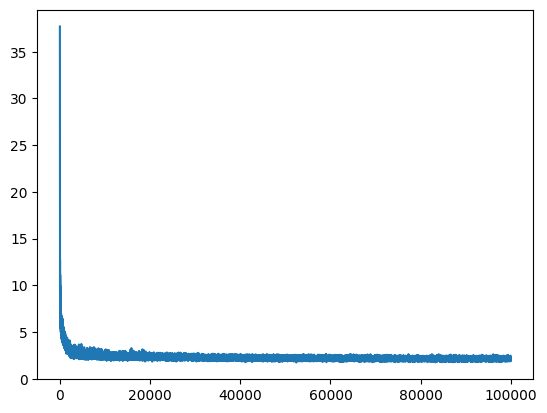

In [8]:
plt.plot(range(len(losses)), losses)

In [10]:
np.array(losses)[-1000:].mean(), np.array(losses)[-1000:].max(), np.array(losses)[-1000:].min()

(2.135714465737343, 2.5469272136688232, 1.8613179922103882)

In [ ]:
emb: Tensor = C[Xte]
h: Tensor = (emb.view(-1, EMBEDDING_SIZE * CONTEXT_LENGTH) @ W1 + b1).sigmoid()
logits: Tensor = h @ W2 + b2
loss: Tensor = F.cross_entropy(logits, Yte)
print("Dev loss:", loss.item())